<a href="https://colab.research.google.com/github/Law101/DSN-and-Microsoft-Skills-for-Job-Hackathon/blob/main/intercampus_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content

drive  sample_data


In [3]:
#Change Directory to the folder containing the data
%cd 'drive/MyDrive/Colab Notebooks/intercampusai_2023'

/content/drive/MyDrive/Colab Notebooks/intercampusai_2023


In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.3 MB/s eta 0:00:00


In [51]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [7]:
!ls

Housing_dataset_test.csv  Housing_dataset_train.csv  intercampus_2023


In [293]:
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')

In [294]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [295]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [296]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             6000 non-null   int64 
 1   loc            6000 non-null   object
 2   title          6000 non-null   object
 3   bedroom        6000 non-null   int64 
 4   bathroom       6000 non-null   int64 
 5   parking_space  6000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 281.4+ KB


In [297]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


<ipython-input-240-b93d258e6640>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

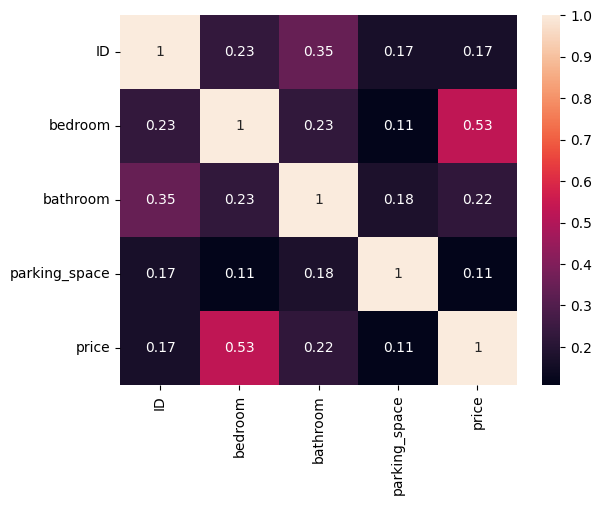

In [240]:
sns.heatmap(train.corr(), annot=True)

In [ ]:
train.groupby(['loc'], as_index=False).sum().sort_values('price', ascending=False)

In [298]:
train['loc'] = train['loc'].astype('category')
train['title'] = train['title'].astype('category')


test['loc'] = test['loc'].astype('category')
test['title'] = test['title'].astype('category')

In [283]:
# train['loc'].fillna(method='bfill', inplace=True)
# train['title'].fillna(method='ffill', inplace=True)
# train['bedroom'].fillna(method='bfill', inplace=True)
# train['bathroom'].fillna(method='bfill', inplace=True)
# train['parking_space'].fillna(method='bfill', inplace=True)

In [299]:
X = train.drop(['price'], axis=1)
y = train['price']

In [300]:
fold = KFold(n_splits=10, shuffle=True, random_state=42)

xgb = XGBRegressor(
    n_estimators=1000,
    booster='gbtree',
    tree_method='hist',
    objective='reg:tweedie',
    enable_categorical=True,
    random_state=20)

lgb = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    objective='tweedie',
    max_depth=-1,
    subsample=0.5,
    random_state=20)


cat = CatBoostRegressor(
    iterations=1000,
    cat_features=['ID', 'loc', 'title'],
    random_seed=20)

In [301]:
def train_test_loop(model, X, y, evaluation_metric, test):
  fold_error = list()
  test_predictions= list()
  for train_index, test_index in fold.split(X,y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]

      model_obj = model
      model_obj.fit(X_train,y_train)
      preds = model_obj.predict(X_test)

      print(f'{str(evaluation_metric)} = {evaluation_metric(y_test,preds, squared=False)}')
      fold_error.append(evaluation_metric(y_test,preds, squared=False))
      test_preds = model_obj.predict(test)
      test_predictions.append(test_preds)

      return np.mean(fold_error), np.mean(test_predictions, axis=0)

In [302]:
fold_error, test_predictions = train_test_loop(lgb, X, y, mean_squared_error, test)

<function mean_squared_error at 0x7eb2659fba30> = 491309.3732712581


In [271]:
fold_error

491309.3732712581

In [230]:
fold_error

491309.3732712581

In [264]:
submission_file = pd.DataFrame()
submission_file['ID'] = test['ID']
submission_file['price'] = test_predictions

In [265]:
submission_file.to_csv(f'lgb{fold_error}.csv', index=False)